Mathias Oyarzun A.

In [152]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import imblearn


### Veamos como esta compuesto nuestro dataset:

In [153]:
data=pd.read_csv('datos/SDSS-DR14.csv')
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Al realizar una búsqueda para entender que significa cada features de este dataset, se encontró que:
    
    ra, dec — ascensión derecha y descendiente
    u, g, r, i, z — longitudes de onda del telescopio
    run, rerun, camcol, field — descriptores de la imagen
    redshift — aumento de la longitud de onda con respecto al movimiento del objeto astronomico
    plate — plate number (parte del telescopio)
    mjd — fecha Julian de la observacion
    fiberid — optic fiber ID
    objid - obj ID
    
Al analizar esta información vemos que existen features que se pueden eliminar de nuestro dataset, como objid, run,rerun,camcol,field,specobjid

In [155]:
data.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid','plate','mjd','fiberid'], axis=1, inplace=True)

Vamos analizar si hay información faltante en el dataset

In [156]:
data.isnull().sum()

ra          0
dec         0
u           0
g           0
r           0
i           0
z           0
class       0
redshift    0
dtype: int64

No hay datos faltantes en el dataset

### Realicemos un analisis de datos preliminares:

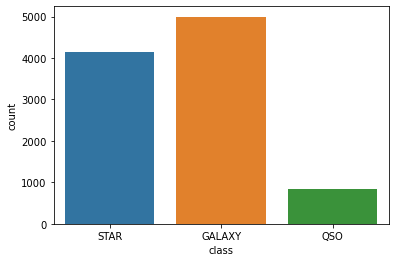

In [157]:
sb.countplot(x='class',data=data)

Se aprecia que el dataset no esta distribuido uniformemente, existen muy pocos Quasars etiquetados.

### Veamos como se encuentran correlacionado nuestro dataset

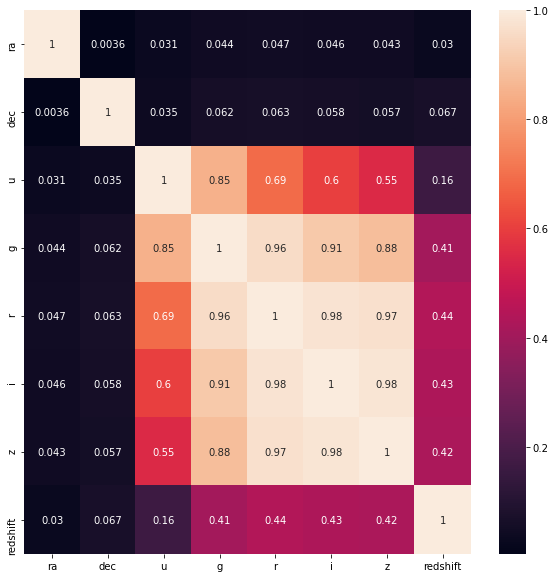

In [158]:
fig, ax = plt.subplots(figsize=(10,10)) 
sb.heatmap(data.corr(), annot=True, ax=ax)


Vemos que existe una fuerte correlación entre g,r,i,z, lo examinaremos para cada etiqueta.

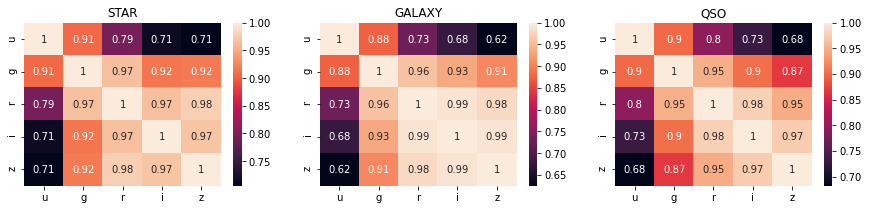

In [159]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.title("STAR")
sb.heatmap(data[data['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(),annot=True)
plt.subplot(1,3,2)
plt.title("GALAXY")
sb.heatmap(data[data['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(),annot=True)
plt.subplot(1,3,3)
plt.title("QSO")
sb.heatmap(data[data['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(),annot=True)


Vemos que para cada elemento existe prácticamente la misma correlación (g,r,i,z), talvez podríamos realizar un PCA para disminuir componentes.

### Analizemos redshift:

Text(0.5, 1.0, 'QSO')

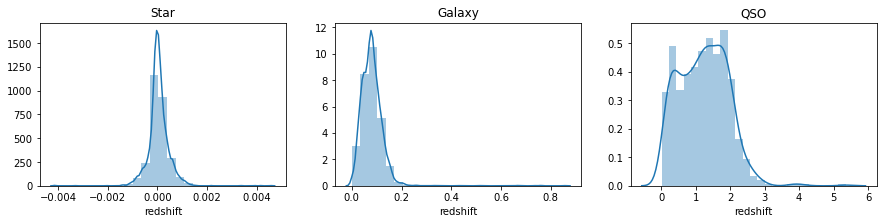

In [160]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
sb.distplot(data[data['class']=='STAR'].redshift, bins = 25  )
plt.title('Star')
plt.subplot(1,3,2)
sb.distplot(data[data['class']=='GALAXY'].redshift, bins = 25  )
plt.title('Galaxy')
plt.subplot(1,3,3)
sb.distplot(data[data['class']=='QSO'].redshift, bins = 25)
plt.title('QSO')

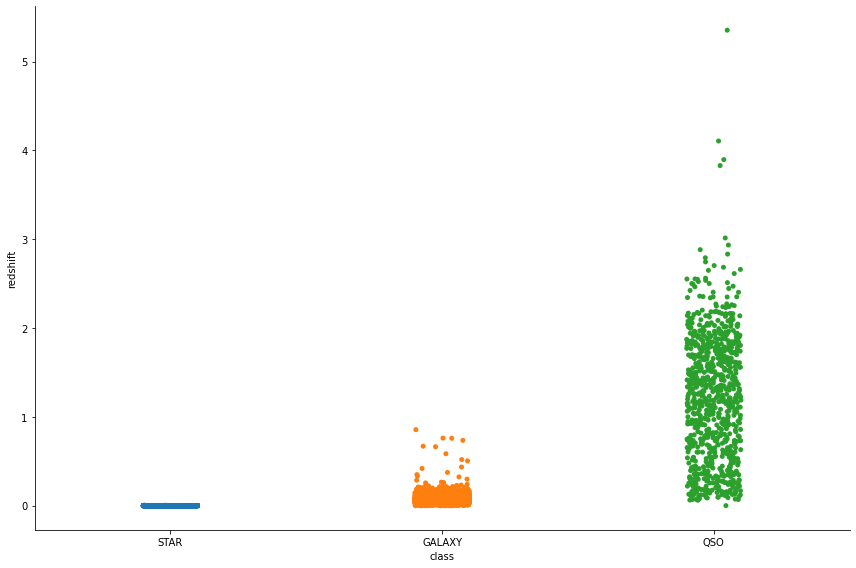

In [161]:
sb.catplot(y='redshift', x='class', data=data, height=8,aspect=1.5)

Vemos que la distribución de STAR, es prácticamente una distribución normal con centro 0, la GALAXY posee una distribución normal un poco achatada hacia la derecha con centro en 0.10 aprox.
Al visualizar el segundo gráfico vemos,redshift sera una excelente característica para etiquetar entre STAR, GALAXY , QSO

### Analicemos ra y dec

Text(0.5, 1.0, 'QSO')

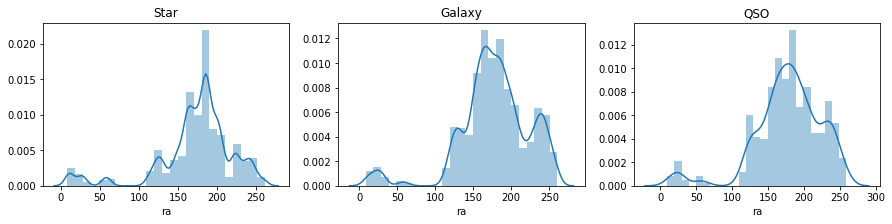

In [162]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
sb.distplot(data[data['class']=='STAR'].ra, bins = 25  )
plt.title('Star')
plt.subplot(1,3,2)
sb.distplot(data[data['class']=='GALAXY'].ra, bins = 25  )
plt.title('Galaxy')
plt.subplot(1,3,3)
sb.distplot(data[data['class']=='QSO'].ra, bins = 25)
plt.title('QSO')

Text(0.5, 1.0, 'QSO')

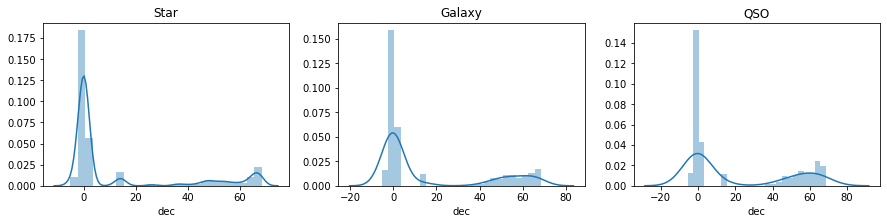

In [163]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
sb.distplot(data[data['class']=='STAR'].dec, bins = 25  )
plt.title('Star')
plt.subplot(1,3,2)
sb.distplot(data[data['class']=='GALAXY'].dec, bins = 25  )
plt.title('Galaxy')
plt.subplot(1,3,3)
sb.distplot(data[data['class']=='QSO'].dec, bins = 25)
plt.title('QSO')

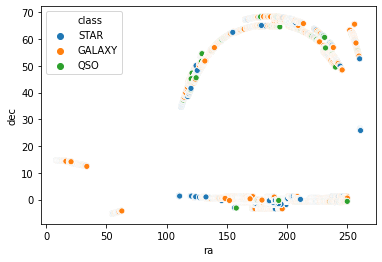

In [164]:
sb.scatterplot(y='dec', x='ra', data=data, hue='class')


Al analizar las distribuciones no se notan grandes diferencias en STAR, GALAXY, QSO.
Al ver el gráfico dec vs ra, se nota que STAR GALAXY QSO, no están distribuidos siguiendo algún claro patrón, sino que están distribuidos de manera random. Esto nos hace pensar que talvez estas dos características no deberíamos incluirlas en nuestro dataset.

In [165]:
data.drop(['dec','ra'], axis=1, inplace=True)

### Preparemos el dataset

In [166]:
y=data['class']
data.drop(['class'],axis=1,inplace=True)
X=data

#### OverSampling

In [197]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
X_over, y_over = oversample.fit_resample(X, y)



#### PCA 

In [198]:
pw = X_over[['g', 'r', 'i', 'z']]
pca = PCA(n_components=1)
pw = pca.fit_transform(pw)
pw = pw.reshape(-1,)


pw = pd.Series(pw, name='pca_wavelength')
X_over = pd.concat([X_over, pw], axis=1)
X_over.drop(['g', 'r', 'i', 'z'], axis=1, inplace=True)
X_over.head()



,u,redshift,pca_wavelength
0,19.47406,-0.000009,-2.716704
1,18.66280,-0.000055,-1.119092
2,19.38298,0.123111,0.221714
3,17.76536,-0.000111,-2.163564
4,17.55025,0.000590,-1.471662


Como mencione anteriormente las longitudes de onda de g,r,i,z tenían una correlación cercana a 1, por lo que reduciré el numero de componentes.

#### Separacion dataset

In [199]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_scaled=scale.fit_transform(X_over)


In [200]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_over, test_size=0.3)

Estandarizamos nuestra información y luego separamos la data para realizar el respectivo entrenamiento y luego la evaluación

### Modelos

In [201]:
precision=[]
score_names=['Regresion Logistica STAR','Regresion Logistica GALAXY','Regresion Logistica QSO','K-Nearest STAR','K-Nearest GALAXY','K-Nearest QSO','Random Forest STAR','Random Forest GALAXY','Random Forest QSO']
recall=[]
f1score=[]
accuracy=[]
#Funcion que recolecta informacion de classification_report para luego graficarla.
def score_list(score):
    for i in y.unique():
        precision.append(score[i]['precision'])
        recall.append(score[i]['recall'])
        f1score.append(score[i]['f1-score'])
    accuracy.append(score['accuracy'])


        

#### Regresion Logistica

In [206]:
lr = LogisticRegression(C=30)
lr.fit(X_train, y_train)
print('Classification report:\n{}'.format(classification_report(y_test, lr.predict(X_test))))
score_lr=classification_report(y_test, lr.predict(X_test),output_dict=True)
score_list(score_lr)
print(confusion_matrix(y_test,lr.predict(X_test)))




Classification report:
              precision    recall  f1-score   support

      GALAXY       0.95      0.97      0.96      1526
         QSO       1.00      0.95      0.97      1452
        STAR       0.97      1.00      0.99      1521

    accuracy                           0.97      4499
   macro avg       0.97      0.97      0.97      4499
weighted avg       0.97      0.97      0.97      4499

[[1482    5   39]
 [  72 1376    4]
 [   0    0 1521]]


Este modelo maneja perfectamente cada unas de las clases a predecir, en los QSO, es donde mas incorrectamente clasifica, ya que 72 QSO lo esta clasificando como Galaxy. Todas las STAR del dataset la clasifica correctamente 1521/1521. Tiene un accuracy de 97%.

Este modelo es fácil de entender y utilizar, tiene buen rendimiento con datasets pequeños/medianos y no es necesario escalar la data. Tiene bajo rendimiento con datasets que no son lineales, no es muy recomendable utilizarlo para grandes datasets.

#### K-Nearest Neighbors


In [207]:
kn=KNeighborsClassifier(n_neighbors=3)
kn.fit(X_train,y_train)
print('Classification report:\n{}'.format(classification_report(y_test, kn.predict(X_test))))
score_kn=classification_report(y_test, kn.predict(X_test),output_dict=True)
score_list(score_kn)
print(confusion_matrix(y_test,kn.predict(X_test)))



Classification report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.91      0.94      1526
         QSO       0.99      1.00      0.99      1452
        STAR       0.93      0.98      0.95      1521

    accuracy                           0.96      4499
   macro avg       0.96      0.96      0.96      4499
weighted avg       0.96      0.96      0.96      4499

[[1384   22  120]
 [   3 1449    0]
 [  30    0 1491]]


Este modelo del mismo modo clasifica perfectamente cada una de las clases, el fuerte de este modelo es clasificar los QSO, de los 1452 QSO del dataset, clasifica 1449 correctamente. Tiene un accuracy del 96%.

Es simple y tiene un algoritmo instintivo, no toma supuesto de la data. Desventajas: Posee una alta complejidad computacional, el numero de neighbors debe ser definido por el usuario, la data debe estar escalada, y no funciona bien con data poca balanceada.

#### Random Forest

In [208]:
rf = RandomForestClassifier(n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print('Classification report:\n{}'.format(classification_report(y_test, rf.predict(X_test))))
score_rf=classification_report(y_test, rf.predict(X_test),output_dict=True)
score_list(score_rf)
print(confusion_matrix(y_test,rf.predict(X_test)))


Classification report:
              precision    recall  f1-score   support

      GALAXY       1.00      0.99      0.99      1526
         QSO       0.99      1.00      1.00      1452
        STAR       0.99      1.00      1.00      1521

    accuracy                           1.00      4499
   macro avg       1.00      1.00      1.00      4499
weighted avg       1.00      1.00      1.00      4499

[[1507    8   11]
 [   0 1452    0]
 [   2    0 1519]]


Este modelo es prácticamente perfecto, es capaz de predecir cada clase con gran precision, recall y f1-score, además posee accuracy 100%, probablemente sufra de overfitting.

Buen rendimiento con data mal balanceada, puede manejar grandes tamaños de datasets, es uno de los algoritmos con mas alto accurate. Desventajas: Puede producir overfit con algunso tipos de dataset, puede ser difícil de interpretar.

[0.6619583 0.2691582 0.0688835]


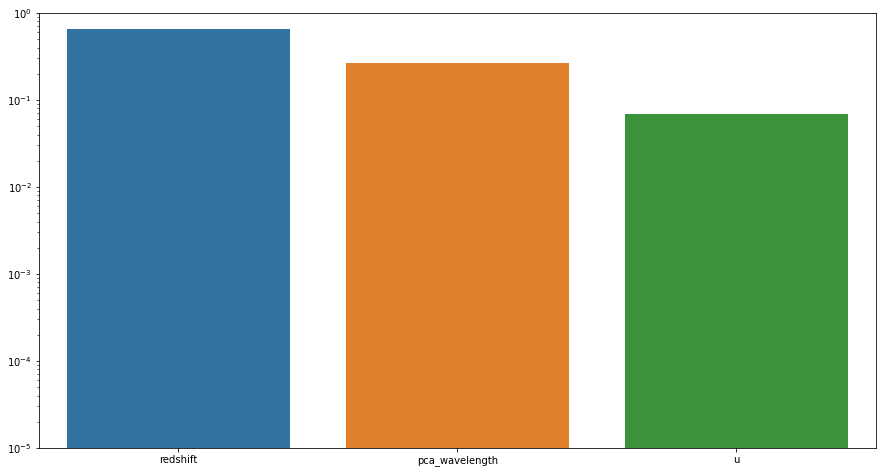

In [205]:
imp = rf.feature_importances_
f = X_over.columns
f_sorted = f[np.argsort(imp)[::-1]]
fig,ax = plt.subplots(figsize=(15,8))
sb.barplot(x=f,y = imp, order = f_sorted,log=True)
plt.ylim(1e-5, 1)

print(np.sort(imp)[::-1])

Como se aprecia en la gráfica que esta representada en logaritmo para una mejor visualización, las componentes principales para la clasificación son redshift con un 66% de importancia y pca_wavelength con un 26%, cabe recordar que esta ultima fue la que creamos usando el PCA.

## Analizando Resultados

Text(0.5, 1.0, 'Precision')

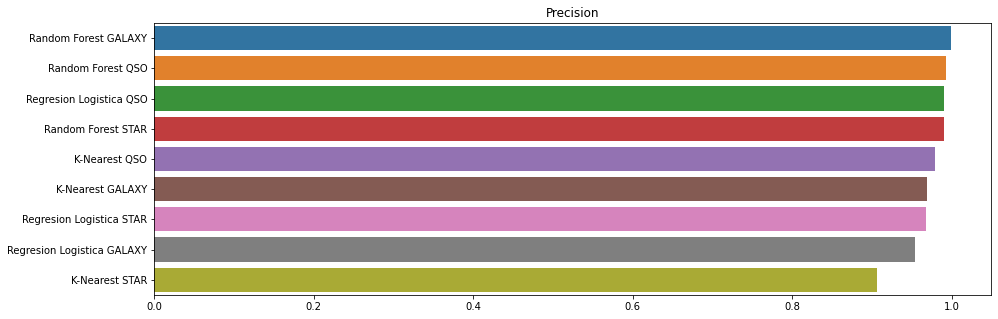

In [178]:
plt.figure(figsize=(15,5))
index=pd.Index(score_names)
index_sorted=index[np.argsort(precision)[::-1]]
sb.barplot(y=index,x=precision,capsize=10,order=index_sorted)
plt.title('Precision')


Text(0.5, 1.0, 'Recall')

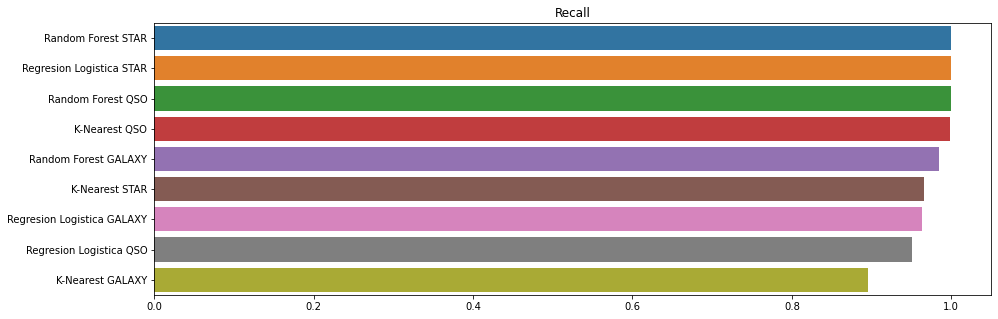

In [179]:
plt.figure(figsize=(15,5))
index=pd.Index(score_names)
index_sorted=index[np.argsort(recall)[::-1]]
sb.barplot(y=index,x=recall,capsize=10,order=index_sorted)
plt.title('Recall')



Text(0.5, 1.0, 'F1-Score')

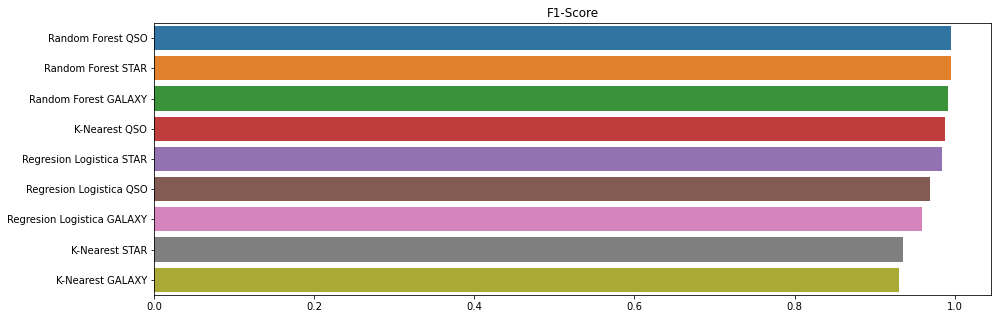

In [180]:
plt.figure(figsize=(15,5))
index=pd.Index(score_names)
index_sorted=index[np.argsort(f1score)[::-1]]
sb.barplot(y=index,x=f1score,capsize=10,order=index_sorted)
plt.title('F1-Score')



Text(0.5, 1.0, 'Accuracy')

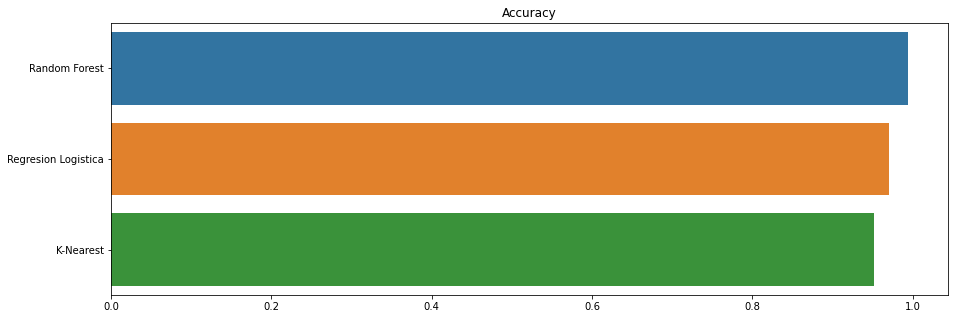

In [181]:
plt.figure(figsize=(15,5))
index=pd.Index(['Regresion Logistica','K-Nearest','Random Forest'])
index_sorted=index[np.argsort(accuracy)[::-1]]
sb.barplot(y=index,x=accuracy,capsize=10,order=index_sorted)
plt.title('Accuracy')



Random Forest, es el que tiene el mejor rendimiento entre todos los parámetros de evaluación. En segundo lugar esta la Regresión Logística y por ultimo esta K-Nearest Neighbors